In [ ]:
import warnings
warnings.filterwarnings('ignore')
import six
import joblib
import sys
sys.modules['sklearn.externals.six'] = six
sys.modules['sklearn.externals.joblib'] = joblib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from get_anomaly_scores import get_anomaly_scores
from statsmodels.graphics.tsaplots import plot_acf
from pyramid.arima import auto_arima
import time
from sklearn.linear_model import LinearRegression
import numpy as np

from statsmodels.tsa.stattools import adfuller

In [2]:
%load_ext rpy2.ipython

# wineind: Australian total wine sales

In [3]:
data = pd.read_csv("data/wineind.csv",header=0)[0:500]
data.head()

,Timestep,Value
0,0,15136
1,1,16733
2,2,20016
3,3,17708
4,4,18019


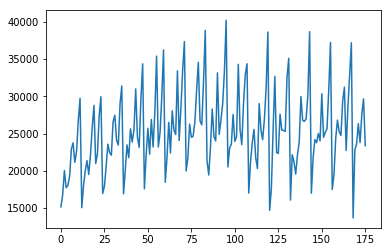

In [4]:
plt.plot(data["Timestep"], data["Value"])
plt.show()

Is there seasonality?

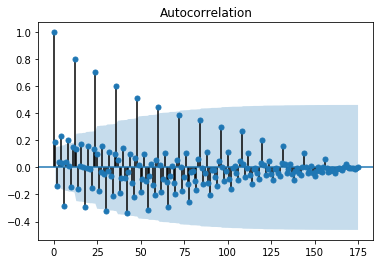

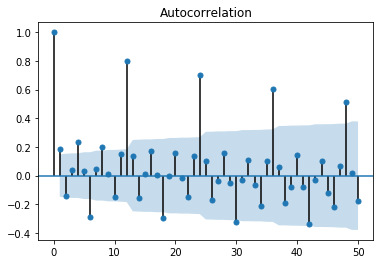

In [5]:
plot_acf(data["Value"])
plt.show()

plot_acf(data["Value"],lags=50)
plt.show()

What is the periodicity?

Is there stochastic/deterministic trend?

In [6]:
result = adfuller(data["Value"])
print('p-value: %f' % result[1])

p-value: 0.051161


Possible stochastic trend. This can be removed via differencing.

Is there deterministic trend?

In [7]:
%%R -i data -w 5 -h 5 --units in -r 200
library("webr")
cox.stuart.test(data[,2])


	Cox-Stuart test for trend analysis

data:  
Increasing trend, p-value = 0.0036717



There is deterministic trend bc p =.0036717. That can be removed using detrending. Let's detrend really quick.

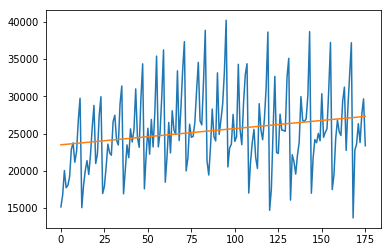

In [8]:
# fit linear model
X = [i for i in range(0, len(data))]
X = np.reshape(X, (len(X), 1))
y = data["Value"].values
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
plt.plot(y)
plt.plot(trend)
plt.show()

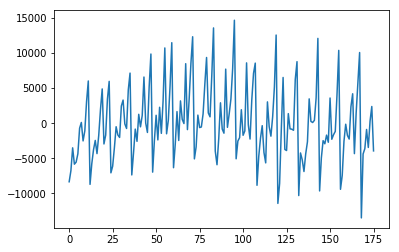

In [9]:
# detrend
detrended = [y[i]-trend[i] for i in range(0, len(data))]
# plot detrended
plt.plot(detrended)
plt.show()

detrended_df = pd.DataFrame({"detrended_value": detrended})

In [10]:
%%R -i detrended_df -w 5 -h 5 --units in -r 200
library("webr")
cox.stuart.test(detrended_df[,1])


	Cox-Stuart test for trend analysis

data:  
Increasing trend, p-value = 0.08272



In [11]:
result = adfuller(detrended)
print('p-value: %f' % result[1])

p-value: 0.503184


In [12]:
data = pd.DataFrame({"Value": detrended})
data.head()

,Value
0,-8346.321263
1,-6771.147852
2,-3509.974440
3,-5839.801028
4,-5550.627616


In [13]:
differenced_data = data - data.shift()
differenced_data.head()

,Value
0,NaN
1,1575.173412
2,3261.173412
3,-2329.826588
4,289.173412


In [14]:
result = adfuller(differenced_data["Value"][1:])
print('p-value: %f' % result[1])

p-value: 0.000000


Differencing once removes the stochastic trend. SARIMA should be able to take care of it because the INTEGRATED portion of SARIMA does differencing.

We have seasonality and trend.

This means we should probably use SARIMA. SARIMA has the following parameters:

p = # of lags, # of AR terms, e.g. if p = 5, we predict $p_t$ by using $p_{t-1}$,$p_{t-2}$, ...$p_{t-5}$

d = # of times we will difference the time series to remove trend (stochastic)

q = # of lagged forecast errors, # of MA terms, e.g. if q = 5, we predict $p_t$ by using $e_{t-1}$,$e_{t-2}$, ...$e_{t-5}$

P = seasonal version of p

D = seasonal version of d

Q = seasonal version of q

s = periodicity

How do we determine these parameters?

s is determined by quickly looking at an ACF, periodogram, findfrequency, etc

d we determined by noticing that we remove stochastic trend by differencing once.

Perform a grid search over the remaining parameters using some kind of performance criteria, like AIC.

Enabling stepwise means we will use a smarter version of grid search (see "Automatic time series for forecasting: the forecast package for R" by Hyndman and Khandakar (2008)). If stepwise is disabled, we will be using a traditional gridsearch. 

In [15]:
stepwise_fit = auto_arima(data["Value"], 
                          start_p=1, 
                          start_q=1, 
                          max_p=3, 
                          max_q=3, 
                          m=12,
                          d=1,
                          start_P=0, 
                          seasonal=True, 
                          trace=True,
                          error_action='ignore', 
                          suppress_warnings=True,  
                          stepwise=True)

stepwise_fit.summary()

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=3587.776, BIC=3594.105, Fit time=0.012 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 12); AIC=3340.795, BIC=3353.454, Fit time=0.491 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 12); AIC=3440.180, BIC=3452.839, Fit time=0.666 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 12); AIC=3573.125, BIC=3582.619, Fit time=0.023 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 0, 12); AIC=3326.975, BIC=3342.799, Fit time=1.732 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(2, 0, 1, 12); AIC=3328.624, BIC=3347.612, Fit time=2.412 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(2, 0, 0, 12); AIC=3360.574, BIC=3373.233, Fit time=0.782 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_order=(2, 0, 0, 12); AIC=3292.174, BIC=3311.163, Fit time=1.917 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_orde

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  176
Model:             SARIMAX(3, 1, 0)x(1, 0, 1, 12)   Log Likelihood               -1629.317
Date:                            Mon, 29 Apr 2019   AIC                           3272.634
Time:                                    10:49:37   BIC                           3294.787
Sample:                                         0   HQIC                          3281.620
                                            - 176                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -192.5170     97.337     -1.978      0.048    -383.295      -1.739
ar.L1         -0.7829      0.074    -10.577      0.000      -0.928      -0.638
ar.L2         -0.6257      0.081     -7.717      0.000      -0.785      -0.467
ar.L3         -0.2627      0.068     -3.858      0.000      -0.396      -0.129
ar.S.L12       0.9705      0.017     55.567      0.000       0.936       1.005
ma.S.L12      -0.5398      0.071     -7.640      0.000      -0.678      -0.401
sigma2      6.574e+06      0.001   5.61e+09      0.000    6.57e+06    6.57e+06
===================================================================================
Ljung-Box (Q):                       57.51   Jarque-Bera (JB):                12.82
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               2.21   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.84e+25. Standard errors may be unstable.
"""

# Train and test our model

In [16]:
train = data[0:125]
test = data[125:]

stepwise_fit.fit(list(train["Value"].values))

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(1, 0, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

# Performance on training data

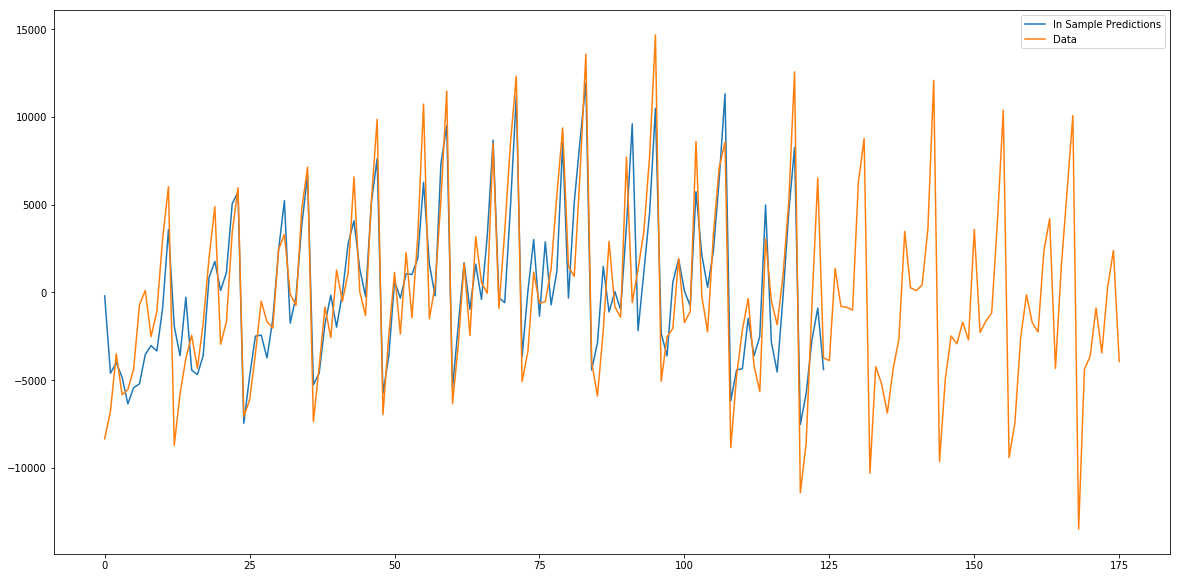

In [17]:
in_sample_preds = stepwise_fit.predict_in_sample()
plt.figure(figsize=(20,10))
plt.plot(in_sample_preds, label="In Sample Predictions")
plt.plot(data["Value"], label="Data")
plt.legend()
plt.show()

# Performance on test data

Over time, your forecasts will drift, and you'll need to update the model with the observed values.

In [18]:
future_forecast = stepwise_fit.predict(n_periods=50)

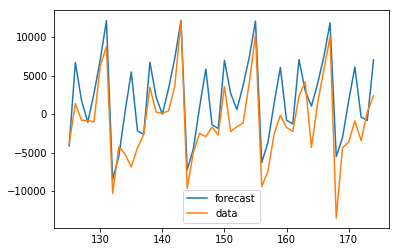

In [19]:
plt.plot([i for i in range(125,175)], future_forecast, label="forecast")
plt.plot([i for i in range(125,175)], data[125:175]["Value"].values, label="data")
plt.legend()
plt.show()


In [20]:
# mean error of predicting on data points 150 to 175
# given that we trained from points 0 to 125
real = data[150:175]["Value"].values
predicted = future_forecast[25:]

errors = []
for i in range(len(predicted)):
    errors.append(abs(predicted[i] - real[i]))
    
print(np.mean(errors))

3493.9802865398433


# Incremental training is needed

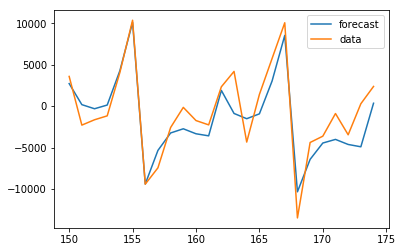

In [21]:
train = data[0:150]
test = data[150:]

stepwise_fit.fit(list(train["Value"].values))

future_forecast = stepwise_fit.predict(n_periods=25)

plt.plot([i for i in range(150,175)], future_forecast, label="forecast")
plt.plot([i for i in range(150,175)], data[150:175]["Value"].values, label="data")
plt.legend()
plt.show()

In [22]:
# mean error of predicting on data points 150 to 175
# given that we trained from points 0 to 150
real = data[150:175]["Value"].values
predicted = future_forecast

errors = []
for i in range(len(predicted)):
    errors.append(abs(predicted[i] - real[i]))
    
print(np.mean(errors))

1887.3655673819924


# How do you determine anomalies?

Could look at confidence intervals. If data, is outside of CI, an anomaly has occurred

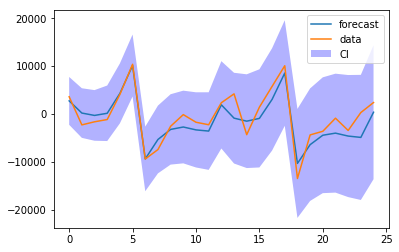

In [23]:
# 95% CI default
predictions, ci = stepwise_fit.predict(n_periods=25, return_conf_int=True)
upper_ci = []
lower_ci = []
for item in ci:
    lower_ci.append(item[0])
    upper_ci.append(item[1])

    
plt.plot(predictions, label="forecast")
plt.fill_between([i for i in range(0,25)], lower_ci, upper_ci, facecolor='blue', alpha=.3, label="CI")
plt.plot(data[150:175]["Value"].values, label="data")
plt.legend()
plt.show()

Could create an anomaly score based off of the forecasting errors. But be careful because you also need incremental training or the error will naturally increase over time.

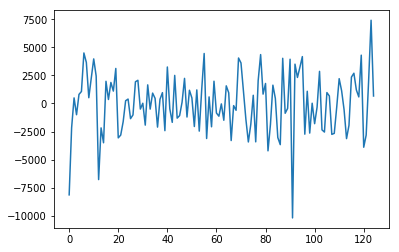

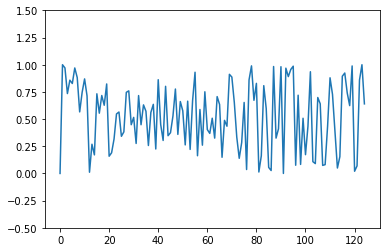

In [24]:
errors = []
for i in range(len(in_sample_preds)):
    errors.append(data["Value"].values[i] - in_sample_preds[i])

plt.plot(errors)
plt.show()

plt.plot(get_anomaly_scores(errors,window_size=25,step_size=50))
plt.ylim([-.5,1.5])
plt.show()

# TIDBITS

1) Github page for pyramid: 

https://github.com/tgsmith61591/pmdarima

Look at documentation here for parameters:

https://github.com/tgsmith61591/pmdarima/blob/master/pmdarima/arima/auto.py

2) More about AIC:

https://en.wikipedia.org/wiki/Akaike_information_criterion

3) More about the Ljung-Box test:

https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test

4) More about the Jarque-Bera test:

https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test

5) Box-Jenkins Methods for choosing p,d,q,P,D,Q,s

https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method

https://stackoverflow.com/questions/43976052/box-jenkins-model-implementation-in-r-or-python

5)  Looking at ACF and PACF plots to choose p,d,q instead of a grid search:

https://people.duke.edu/~rnau/411arim3.htm

6) Automatic time series forecasting: the forecast package for R by Hyndman and Khandakar

http://webdoc.sub.gwdg.de/ebook/serien/e/monash_univ/wp6-07.pdf